In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_4mm_smear.h5',"MC/hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_1mmbin.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_1mmstep_high_E_slim_smear.h5","hits")


# hits = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF0_779551_24.h5", "hits")

hits = pd.read_hdf("../../NEXT_nudobe/files/data/mbb_0_1mm_smear.h5", "MC/hits")

# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_SF0_779552_232.h5", "hits")

display(hits)


,event_id,x,y,z,energy
0,25,-103.840393,-261.915833,-263.332825,0.000050
1,25,-103.819847,-261.380035,-263.332062,0.000025
2,25,-103.791435,-260.154633,-263.212982,0.000075
3,25,-103.966301,-262.919067,-263.067230,0.000800
4,25,-103.780540,-258.973053,-263.050903,0.000075
...,...,...,...,...,...
106192,46,578.814880,-2124.820312,1061.538940,0.002625
106193,46,579.047791,-2124.431641,1061.704956,0.005225
106194,46,511.340515,-2186.816406,1130.484253,0.000525
106195,46,511.372131,-2186.282471,1130.706299,0.014375


In [2]:
# Function to walk along a track segment till we get to an end
def GetNodePath(graph, start_node, forward_node):
    path = [start_node]
    
    query = forward_node
    prev_node = start_node 

    for index,n in enumerate(range(len(graph))):

        path.append(query)
        
        # Get the connected nodes
        con_nodes = graph[query]

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return path
        
        if (len(con_nodes) == 3 ):
            new_list = con_nodes.remove(prev_node)
            len1 = len(GetNodePath(graph, query, con_nodes[0]))
            len2 = len(GetNodePath(graph, query, con_nodes[1]))

            if (len1 > len2):
                prev_node = query
                query = con_nodes[0]
            else:
                prev_node = query
                query = con_nodes[1]
            
            continue

            print("help!!")

        if (len(con_nodes) > 3 ):
            print("Error too many nodes in pathing that I was anticipating...")

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]

,x,y,z,energy
0,-1130.761597,338.401764,-227.770859,0.000125
1,-1130.724731,338.465820,-227.026917,0.000900
2,-1130.524658,338.334198,-228.526108,0.000025
3,-1130.431152,338.319458,-228.788681,0.000050
4,-1130.180054,338.405609,-226.987000,0.001300
...,...,...,...,...
5321,26.259537,30.728107,10.460077,0.000025
5322,26.275051,30.056385,11.930923,0.000200
5323,26.291346,29.023361,14.033312,0.000075
5324,26.342072,29.380983,13.290472,0.000425


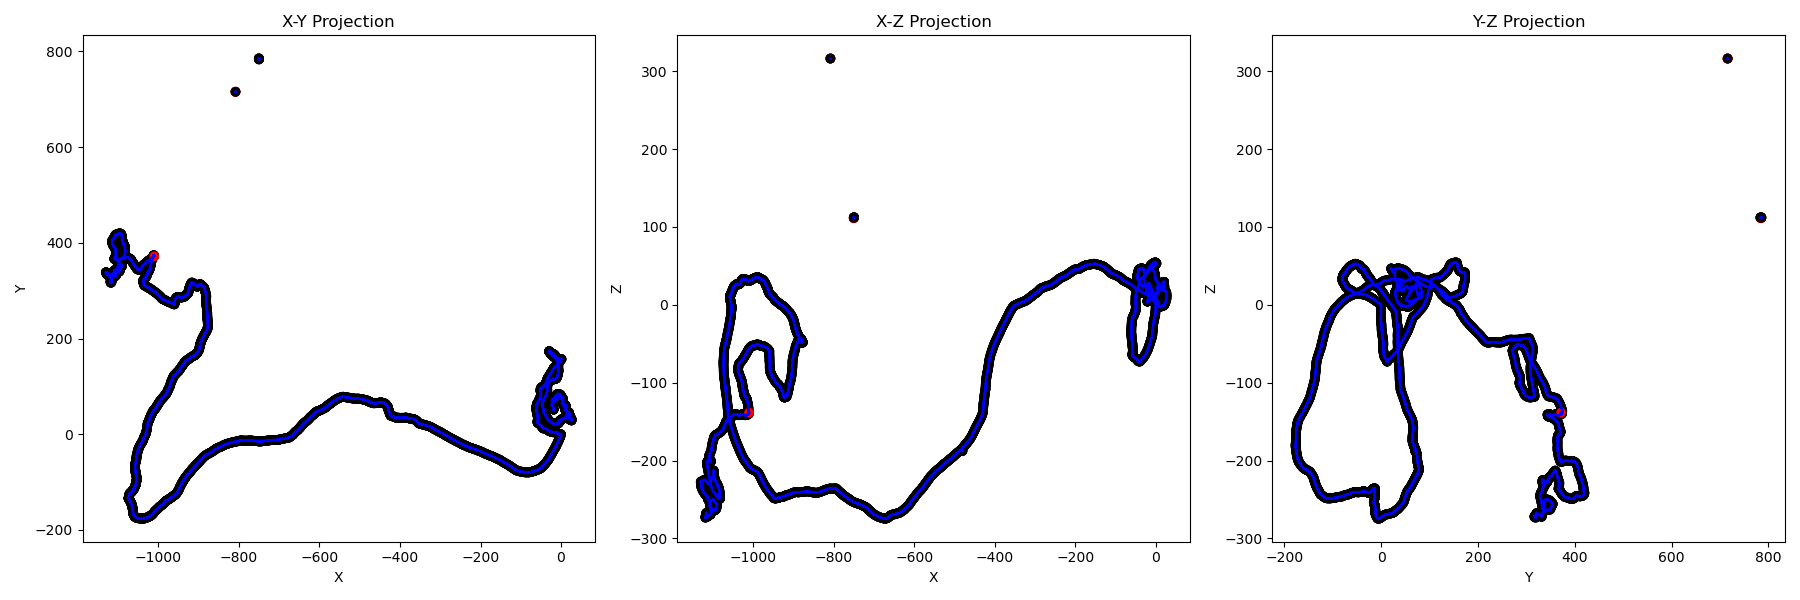

In [3]:
%matplotlib widget

data = hits[hits.event_id ==28]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break




# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

{'id': 0, 'start': 65, 'end': 5166, 'nodes': [65, 64, 63, 61, 60, 66, 57, 55, 53, 51, 54, 59, 68, 70, 72, 77, 86, 94, 96, 91, 82, 74, 73, 75, 71, 76, 79, 81, 87, 90, 92, 93, 89, 84, 83, 85, 88, 95, 97, 101, 103, 99, 98, 104, 111, 128, 140, 150, 155, 164, 169, 185, 197, 204, 222, 238, 247, 254, 259, 279, 291, 303, 304, 308, 311, 316, 321, 323, 331, 334, 335, 356, 359, 362, 367, 371, 379, 388, 401, 405, 414, 430, 435, 440, 448, 454, 457, 459, 463, 468, 470, 472, 476, 481, 483, 485, 487, 491, 497, 502, 505, 509, 512, 518, 522, 523, 527, 539, 544, 543, 545, 546, 542, 533, 530, 521, 515, 514, 507, 500, 496, 494, 490, 486, 477, 473, 465, 460, 456, 450, 443, 429, 419, 418, 409, 392, 387, 383, 376, 373, 366, 360, 350, 340, 326, 309, 294, 251, 244, 235, 231, 234, 246, 253, 255, 260, 266, 278, 301, 306, 313, 319, 327, 338, 341, 337, 348, 339, 325, 315, 310, 288, 275, 264, 262, 249, 232, 226, 217, 220, 225, 219, 223, 221, 218, 206, 195, 184, 170, 162, 158, 151, 147, 146, 141, 138, 135, 133, 123, 

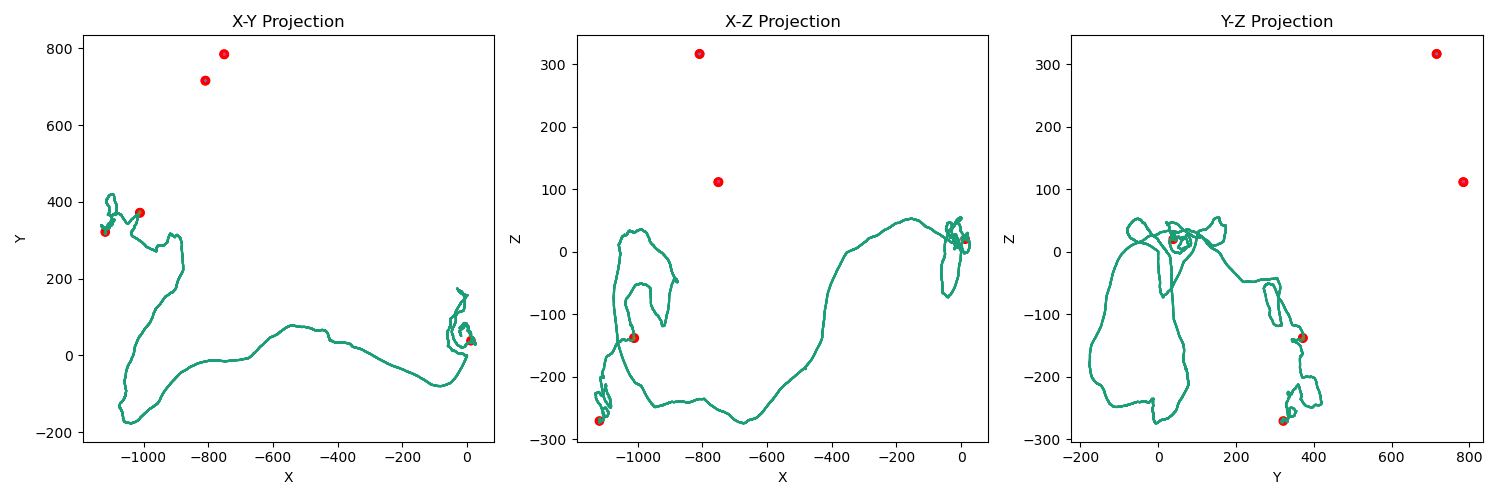

In [4]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [5]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)
# dist_threshold = 10

0.691


In [6]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


# search connections made and make sure to get the merged id
def GetDaughterConnectionID(id_, dict_):
    for ids in dict_:
        if (ids == id_):
            return GetDaughterConnectionID(dict_[id_], dict_)
        
    print("Daughter ID is: ",id_)
    return id_

# This is
def AddConnectedTracks(curr_track,conn_track, delta_path, seg1_path, seg2_path, UpdatedTracks_, data):

    # Get the ids before popping
    delta_id   = GetUniqueTrackID(UpdatedTracks_)
    primary_id =  GetUniqueTrackID(UpdatedTracks_)+1

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks_):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            print("popping:", t["id"])
            UpdatedTracks_.pop(index)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks_):
        # remove the old tracks
        if (t["id"] == conn_track):
            print("popping:", t["id"])
            UpdatedTracks_.pop(index)


    delta_len, delta_e = GetTrackLengthEnergy(delta_path, data)
    Delta = {"id":delta_id, "start":delta_path[0], "end":delta_path[-1], "nodes":delta_path, "length":delta_len, "energy":delta_e,"label":"track","c":"black"}
    UpdatedTracks_.append(Delta)
    
    joined_track_path = join_tracks(seg1_path, seg2_path)
    total_length_joined, total_energy_joined = GetTrackLengthEnergy(joined_track_path, data)
    color = next(color_cycle)
    
    Primary = {"id":primary_id, "start":joined_track_path[0], "end":joined_track_path[-1], "nodes":joined_track_path, "length":total_length_joined, "energy":total_energy_joined,"label":"track","c":"black"}
    UpdatedTracks_.append(Primary)
    print("prim id is: ", Primary["id"])


# Update an existing track in the updated tracks array from the merging of two tracks
def UpdateAndMergeTrack(curr_track,conn_track, newpath, UpdatedTracks_, data):

    name=""
    color = "black"
    primary_id = GetUniqueTrackID(UpdatedTracks_)
    
    for index, t in enumerate(UpdatedTracks_):
        
        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks_):
            
            # remove the old tracks
            if (t["id"] == curr_track):
                UpdatedTracks_.pop(index)

        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks_):
            # remove the old tracks
            if (t["id"] == conn_track):
                # name=t["label"]
                # color = t["c"]
                UpdatedTracks_.pop(index)

    # Add the new merged track
    length, energy = GetTrackLengthEnergy(newpath, data)
    print(newpath[0], newpath[-1], newpath)
    Primary = {"id":primary_id, "start":newpath[0], "end":newpath[-1], "nodes":newpath, "length":length, "energy":energy,"label":"track","c":"black"}
    UpdatedTracks_.append(Primary)



In [7]:

def ConnectTracks(Tracks_):

    # UpdatedTracks = copy.deepcopy(Tracks_)

    # Dont run this if we only got one track!
    if (len(Tracks_) == 1):
        return True, Tracks_

    for idx, Track in enumerate(Tracks_):

        # Current track
        curr_track = Track["id"]
        print(curr_track)
        
        start_node = Track["start"]
        end_node   = Track["end"]

        # Get the indexes of closest nodes to start and end
        dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
        dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

        # Filter nodes that are in the current track
        dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
        dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

        # Distances of the end point to the closest track
        dist_start = dist_matrix[start_node][dist_ind_start[0]]
        dist_end   = dist_matrix[end_node][dist_ind_end[0]]

        # Apply threshold. If both nodes fail here then no need to continue
        if (dist_start > dist_threshold and dist_end > dist_threshold):
            # print("Failed distance requirements")
            continue

        # First find the node with the closest track
        closest_idx = 0
        end_conn_node = 0
        con_point = "start"
        curr_track_path = Track["nodes"]

        # Choose the smallest index
        if dist_start < dist_end:
            closest_idx = dist_ind_start[0]
            end_conn_node = start_node

            if (dist_start > dist_threshold):
                # print(" Start Failed distance requirements")
                continue
            
        else:
            closest_idx = dist_ind_end[0]
            end_conn_node = end_node
            con_point = "end"

            # Apply threshold
            if (dist_end > dist_threshold):
                # print(" End Failed distance requirements")
                continue

        print("Closest index is:", closest_idx)

        # Get the track ID where the connecting node is located
        con_track      = GetTrackwithNode(closest_idx, Tracks_)

        # Check if that index has changed, use that track
        con_track_dict = GetTrackDictwithNode(closest_idx, Tracks_)

        # The current node should not have more than 2 connections as its an end
        # The connecting node should not have more than 3 connections
        if (connection_count[closest_idx] >= 3 or connection_count[end_conn_node] >= 2):

            # Remove the old tracks from the array
            for j, t in enumerate(Tracks_):
                
                # Change the color to black
                if (t["id"] == curr_track):
                    Tracks_[j]["c"] = "black"
            print("node already has three connecitons,skipping...")
            continue

        # Check if the current track is connected to the proposed track already
        if (set(Track["nodes"]) & set(con_track_dict["nodes"])):
            
            # Remove the old tracks from the array
            for j, t in enumerate(Tracks_):
                
                # Change the color to black
                if (t["id"] == curr_track):
                    Tracks_[j]["c"] = "black"
                    
            print("the trying to connect both ends of track to the same track")
            continue



        # if node-node then merge nodes and update track in Tracks
        if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
            # print(curr_track, con_track, closest_idx, con_track_dict["start"], con_track_dict["end"])
            
            if (con_point == "start"):
                curr_track_path.insert(0,closest_idx)
                newpath = join_tracks(curr_track_path, con_track_dict["nodes"])
            else:
                curr_track_path.append(closest_idx)
                newpath = join_tracks(curr_track_path, con_track_dict["nodes"])
        
            UpdateAndMergeTrack(curr_track, con_track, newpath, Tracks_, data)
            UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
            print("Here1")
            return False, Tracks_

        # Check if the proposed connection will form a cycle
        cycle  = Testcycle(end_conn_node, closest_idx ,connected_nodes, connections, connection_count)

        if not cycle:

            if (con_point =="start"):
                curr_track_path.insert(0,closest_idx)
            else:
                curr_track_path.append(closest_idx)

            Track["nodes"] = curr_track_path
            UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
            print("Here 5")
        else:
            continue

        # Get the length either side of track
        seg1_path = GetNodePath(connected_nodes, closest_idx, connected_nodes[closest_idx][0])
        seg2_path = GetNodePath(connected_nodes, closest_idx, connected_nodes[closest_idx][1])

        # Now get the lengths and energies of the track segments
        total_length_seg1, total_energy_seg1 = GetTrackLengthEnergy(seg1_path, data)
        total_length_seg2, total_energy_seg2 = GetTrackLengthEnergy(seg2_path, data) 
        total_length_seg3, total_energy_seg3 = GetTrackLengthEnergy(curr_track_path, data) 

        # Find the delta and the primary track and add them to the new track list
        if (total_length_seg1 < total_length_seg2 and total_length_seg1 < total_length_seg3):
            AddConnectedTracks(curr_track, con_track, seg1_path, seg2_path, curr_track_path, Tracks_, data)
            print("Here2")
            return False, Tracks_
        
        elif ((total_length_seg2 < total_length_seg1 and total_length_seg2 < total_length_seg3)):
            print(2667 in seg1_path)
            print(2667 in seg2_path)
            print(2667 in curr_track_path)
            print("curr:", curr_track, " conn: ", con_track)

            for t in Tracks_:
                if 2667 in t["nodes"]:
                    print(t["id"])
                    print("Huzzah2!")
            
            AddConnectedTracks(curr_track, con_track, seg2_path, seg1_path, curr_track_path, Tracks_, data)

            for t in Tracks_:
                if 2667 in t["nodes"]:
                    print(t["id"])
                    print("Huzzah2!")
            # print(seg1_path)
            # print(seg2_path)
            # print(curr_track_path)
            print("Here3")
            return False, Tracks_
        
        else:

            for j, t in enumerate(Tracks_):
                
                # Change the color to black
                if (t["id"] == curr_track):
                    Tracks_[j]["c"] = "black"

            print("Here4")
            continue

    return True, Tracks_


finished = False  # Initial state

# Tracks = copy.deepcopy(Tracks)

while not finished:
    print("Lengths of tracks1:", len(Tracks))
    finished, Tracks = ConnectTracks(Tracks)
    for t in Tracks:
        if 2667 in t["nodes"]:
            print(t["id"])
            print("Huzzah!")
    print("Lengths of tracks2:", len(Tracks))

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)




Lengths of tracks1: 4
0
1
Closest index is: 1515
Here 5
Here4
3
5
0
Huzzah!
Lengths of tracks2: 4
True
Total Tracks: 4
{'id': 0, 'start': 65, 'end': 5166, 'nodes': [65, 64, 63, 61, 60, 66, 57, 55, 53, 51, 54, 59, 68, 70, 72, 77, 86, 94, 96, 91, 82, 74, 73, 75, 71, 76, 79, 81, 87, 90, 92, 93, 89, 84, 83, 85, 88, 95, 97, 101, 103, 99, 98, 104, 111, 128, 140, 150, 155, 164, 169, 185, 197, 204, 222, 238, 247, 254, 259, 279, 291, 303, 304, 308, 311, 316, 321, 323, 331, 334, 335, 356, 359, 362, 367, 371, 379, 388, 401, 405, 414, 430, 435, 440, 448, 454, 457, 459, 463, 468, 470, 472, 476, 481, 483, 485, 487, 491, 497, 502, 505, 509, 512, 518, 522, 523, 527, 539, 544, 543, 545, 546, 542, 533, 530, 521, 515, 514, 507, 500, 496, 494, 490, 486, 477, 473, 465, 460, 456, 450, 443, 429, 419, 418, 409, 392, 387, 383, 376, 373, 366, 360, 350, 340, 326, 309, 294, 251, 244, 235, 231, 234, 246, 253, 255, 260, 266, 278, 301, 306, 313, 319, 327, 338, 341, 337, 348, 339, 325, 315, 310, 288, 275, 264, 262, 2

In [8]:
# Re-Color the tracks

temp_length = 0
primary_track_id = -1
primary_nodes = []

# Get the primary track 
for t in Tracks:

    if (len(t["nodes"]) > temp_length):
        temp_length = len(t["nodes"]) 
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]
    
print("Primary Track is: ",  primary_track_id)

# Now find tracks connected to the primary
# if connected, label with dark-red, else give it a different colour

for t in Tracks:

    if (t["id"] == primary_track_id):
        t["label"] = "primary"
        t["c"] = "LightGreen"
        continue
    
    # Color for Brems
    if (len(t["nodes"]) == 1):
        t["c"] = "Orange"
        t["label"] = "track"
        continue

    # Check for common elements to the primary track
    # if true then it is a delta
    common_elements = set(t["nodes"]) & set(primary_nodes)

    if common_elements:
        t["c"] = "DarkRed"
        t["label"] = "track"
    else:
        t["c"] = next(color_cycle)
        t["label"] = "track"




Primary Track is:  0


In [9]:
for c in connection_count:
    if (c>2):print(c)

3


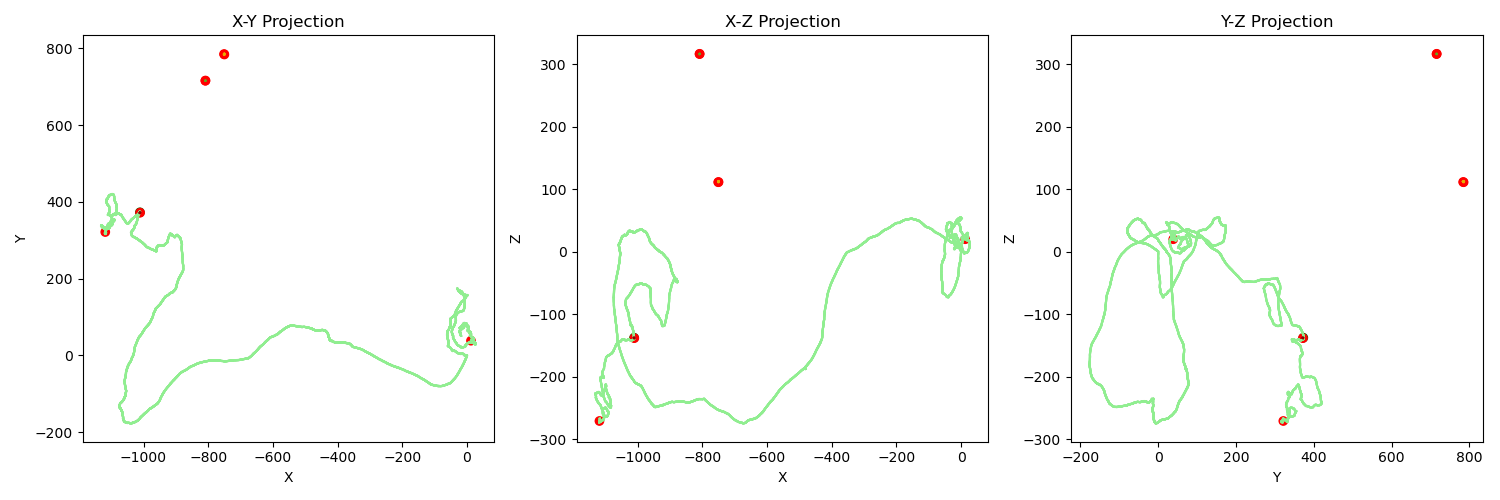

In [10]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [11]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in Tracks:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)



Primary_Track = data.reindex(primary_nodes)


# Take the mean every ten rows
# Primary_Track = Primary_Track.groupby(np.arange(len(Primary_Track)) // 10).mean()


display(Primary_Track)


# Function to calculate the Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Function to calculate the angle between two vectors
def angle_between_vectors(v1, v2):
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    # Ensure the value is within [-1, 1] due to floating-point precision
    cos_theta = np.clip(cos_theta, -1, 1)
    angle = np.arccos(cos_theta)
    return np.degrees(angle)


# Get the diff between each row
distances = [0]
for i in range(1, len(Primary_Track)):
    
    prev_point = Primary_Track.iloc[i - 1][['x', 'y', 'z']].to_numpy()
    curr_point = Primary_Track.iloc[i][['x', 'y', 'z']].to_numpy()
    distances.append(euclidean_distance(curr_point,prev_point))


cum_distance = []
sum_ = 0
for d in distances:
    sum_ = sum_+d
    cum_distance.append(sum_)

cum_distance = np.array(cum_distance)


angles = [0]  # First point has no preceding point for angle calculation

# Iterate through the points
for i in range(1, len(Primary_Track)):
    # Current and previous points
    prev_point = Primary_Track.iloc[i - 1][['x', 'y', 'z']].to_numpy()
    curr_point = Primary_Track.iloc[i][['x', 'y', 'z']].to_numpy()
    
    
    # Calculate angle between the vectors
    if i > 1:  # Skip the first vector, as there's no previous vector
        prev_vector = prev_point - Primary_Track.iloc[i - 2][['x', 'y', 'z']].to_numpy()
        curr_vector = curr_point - prev_point

        angle = angle_between_vectors(prev_vector, curr_vector)
        angles.append(angle)
    else:
        angles.append(0)  # No angle for the first vector

# Add the cumulative distances and angles as new columns
Primary_Track['cumulative_distance'] = cum_distance
Primary_Track['angle'] = angles

Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(Primary_Track)




The primary track is:  0


,x,y,z,energy
65,-1118.331055,321.500122,-271.127991,0.000050
64,-1118.344482,321.342010,-271.140564,0.019475
63,-1118.523071,320.862122,-271.311401,0.001950
61,-1118.566772,320.557495,-271.545197,0.000425
60,-1118.606567,320.015503,-271.936768,0.004550
...,...,...,...,...
5163,12.390084,37.451580,19.925539,0.004300
5170,12.543677,37.995075,20.070572,0.008400
5165,12.466014,38.044895,20.068701,0.005750
5169,12.536088,38.536312,19.851082,0.006800


,x,y,z,energy,cumulative_distance,angle
0,-1118.331055,321.500122,-271.127991,0.000050,0.000000,0.000000
1,-1118.344482,321.342010,-271.140564,0.019475,0.159178,0.000000
2,-1118.523071,320.862122,-271.311401,0.001950,0.698968,20.612721
3,-1118.566772,320.557495,-271.545197,0.000425,1.085448,21.626794
4,-1118.606567,320.015503,-271.936768,0.004550,1.755274,3.501013
...,...,...,...,...,...,...
5299,12.390084,37.451580,19.925539,0.004300,4004.190102,8.792943
5300,12.543677,37.995075,20.070572,0.008400,4004.773208,88.691671
5301,12.466014,38.044895,20.068701,0.005750,4004.865496,73.951419
5302,12.536088,38.536312,19.851082,0.006800,4005.407491,67.120587


Text(0, 0.5, 'Scatter Angle [deg]')

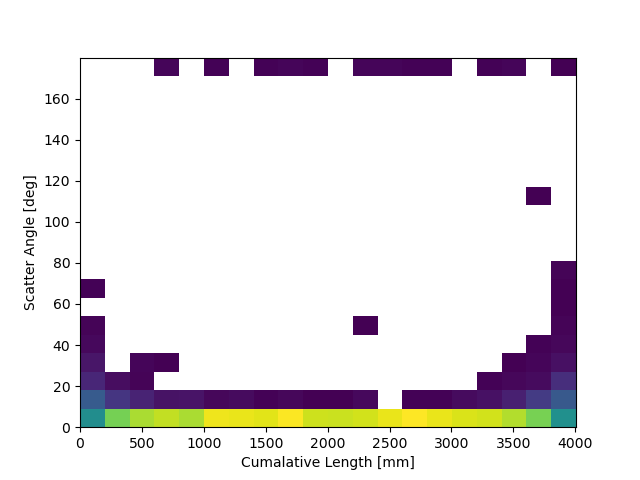

In [12]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

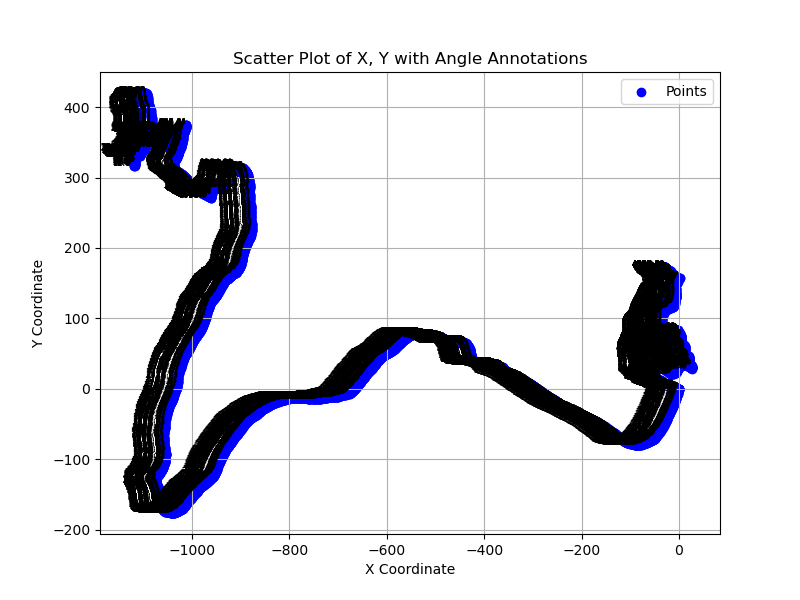

In [13]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.loc[i, 'x']
    y = Primary_Track.loc[i, 'y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()